LinearRegression Model:
Mean Squared Error: 9.026746952330518
Accuracy: 99.41235127359657 

RandomForestRegressor Model:
Mean Squared Error: 22.906238407669353
Accuracy: 99.21512713559814 

SVR Model:
Mean Squared Error: 17.916213256595448
Accuracy: 99.18978354056809 

GradientBoostingRegressor Model:
Mean Squared Error: 25.29843618369242
Accuracy: 99.15521878197278 



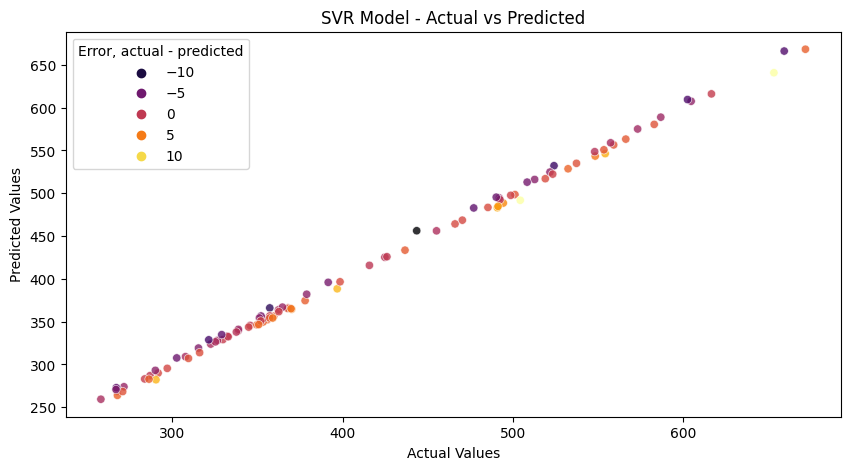

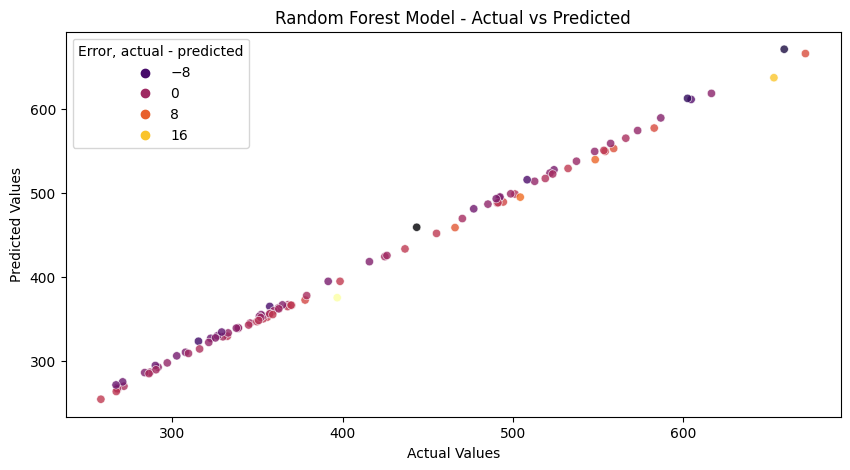

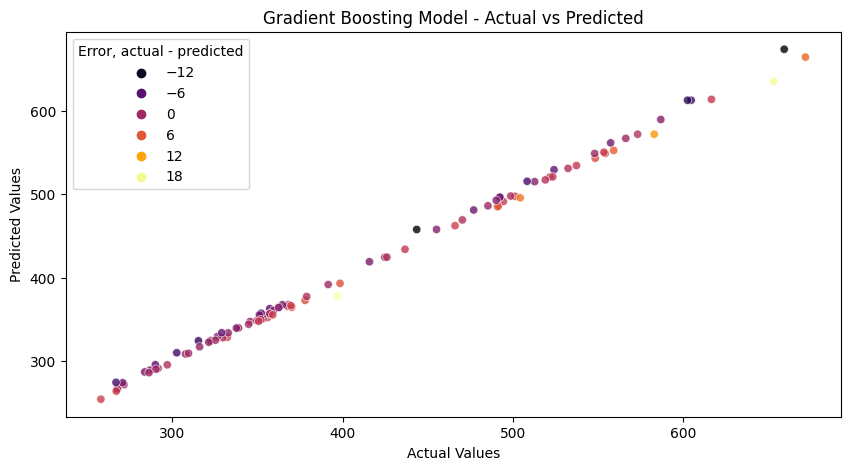

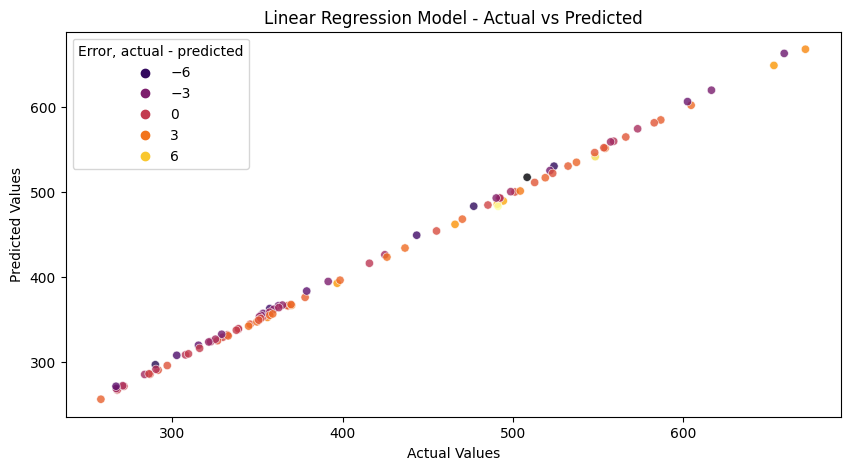

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

def accuracy(y_true, y_pred):
    errors = abs(y_true - y_pred)
    mape = 100 * np.mean(errors / y_true)
    accuracy = 100 - mape
    return accuracy

def preprocess_data(data):
    data.drop('Adj Close', axis=1, inplace=True)
    data['Day'] = data['Date'].dt.day
    data['Month'] = data['Date'].dt.month
    data['Year'] = data['Date'].dt.year
    data.drop('Date', axis=1, inplace=True)
    data['is_quarter_end'] = np.where(data['Month'] % 3 == 0, 1, 0)
    numerical_cols = ['Day', 'Month', 'Year', 'Open', 'Low', 'High', 'Volume']
    high_vol, low_vol = find_outlier_limits(data, 'Volume')
    data.loc[data['Volume'] > high_vol, 'Volume'] = high_vol
    data.loc[data['Volume'] < low_vol, 'Volume'] = low_vol
    scaler = StandardScaler()
    data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
    columns_order = ['Day', 'Month', 'Year', 'Open', 'Low', 'High', 'Volume','is_quarter_end', 'Near_Support', 'Near_Resistance', 'Close']
    data = data[columns_order]
    return data

def identify_support_resistance(data):
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['SMA_200'] = data['Close'].rolling(window=200).mean()
    data['Near_Support'] = np.where(data['Close'] <= data['SMA_50'], 1, 0)
    data['Near_Resistance'] = np.where(data['Close'] >= data['SMA_200'], 1, 0)
    return data

def find_outlier_limits(data, col_name):
    Q1, Q3 = data[col_name].quantile([.25, .75])
    IQR = Q3 - Q1
    low = Q1 - (1.5 * IQR)
    high = Q3 + (1.5 * IQR)
    return high, low

def train_evaluate_model(model, X_train, X_test, y_train, y_test, param_distributions=None):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    if param_distributions:
        rand_search = RandomizedSearchCV(model, param_distributions, n_iter=10, cv=5, random_state=42, n_jobs=-1)
        rand_search.fit(X_train_scaled, y_train)
        model = rand_search.best_estimator_
    else:
        model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, predictions)
    accuracy_percentage = accuracy(y_test, predictions)
    print(f"{model.__class__.__name__} Model:")
    print("Mean Squared Error:", mse)
    print("Accuracy:", accuracy_percentage, "\n")
    return predictions

def visualize_predictions(actual, predicted, model_name):
    plt.figure(figsize=(10, 5))
    residuals = actual - predicted
    sns.scatterplot(x=actual, y=predicted, hue=residuals, palette='inferno', alpha=0.8)
    plt.title(f"{model_name} - Actual vs Predicted")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.legend(title='Error, actual - predicted')
    plt.show()

data = pd.read_excel('/content/drive/MyDrive/corizo_projects/StockMarket/StockMarket.xlsx')
data = identify_support_resistance(data)
data = preprocess_data(data)

X = data[['Year', 'Open', 'Low', 'High', 'Volume', 'is_quarter_end', 'Near_Support', 'Near_Resistance']]
y = data['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=440)

predictions_lr = train_evaluate_model(LinearRegression(), X_train, X_test, y_train, y_test)
predictions_rf = train_evaluate_model(RandomForestRegressor(n_estimators=100, min_samples_split=3), X_train, X_test, y_train, y_test)
predictions_svr = train_evaluate_model(SVR(kernel='rbf', C=100, epsilon=0.1), X_train, X_test, y_train, y_test)
predictions_gb = train_evaluate_model(GradientBoostingRegressor(), X_train, X_test, y_train, y_test)

visualize_predictions(y_test, predictions_svr, "SVR Model")
visualize_predictions(y_test, predictions_rf, "Random Forest Model")
visualize_predictions(y_test, predictions_gb, "Gradient Boosting Model")
visualize_predictions(y_test, predictions_lr, "Linear Regression Model")